<a href="https://colab.research.google.com/github/nahumsa/Tensorflow-Quantum/blob/master/Binary%20Quantum%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binary Classification of Quantum States

Based on this [notebook](https://github.com/tensorflow/quantum/blob/research/binary_classifier/binary_classifier.ipynb).

The idea is to reproduce the [Tensorflow Quantum Whitepaper](https://arxiv.org/pdf/2003.02989.pdf)

## Installing and importing dependencies

In [0]:
!pip install --upgrade cirq==0.7.0

In [0]:
!pip install --upgrade tensorflow==2.1.0
!pip install qutip

In [0]:
!pip install tensorflow-quantum

In [0]:
try:
  %tensorflow_version 2.x
  
except Exception:
  pass  

In [0]:
import cirq 
import numpy as np
import qutip
import random
import sympy
import tensorflow as tf
import tensorflow_quantum as tfq

#Visualization
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

## Data Generation

We will separate the bloch sphere into two blobs and give them different labels that we want to classify.

In [0]:
def generate_dataset(qubit, theta_a, theta_b, num_samples):
  """Generate a dataset of points on `qubit` near the two given angles; labels
  for the two clusters use a one-hot encoding.
  """
  
  q_data = []
  
  bloch = {"a": [[], [], []], "b": [[], [], []]}
  
  labels = []
  blob_size = abs(theta_a - theta_b) / 5
  
  for _ in range(num_samples):
    
    coin = random.random()
    spread_x = np.random.uniform(-blob_size, blob_size)
    spread_y = np.random.uniform(-blob_size, blob_size)
    
    if coin < 0.5:
      label = [1, 0]
      angle = theta_a + spread_y
      source = "a"
    
    else:
      label = [0, 1]
      angle = theta_b + spread_y
      source = "b"

    #Label: [1,0] if theta_a and [0,1] if theta_b
    labels.append(label)

    #Q_data: Construct the circuit with 2 rotations RX and Ry
    q_data.append(cirq.Circuit(cirq.ry(-angle)(qubit), 
                               cirq.rx(-spread_x)(qubit)))
    
    #Projections on the Bloch Sphere
    bloch[source][0].append(np.cos(angle))
    bloch[source][1].append(np.sin(angle)*np.sin(spread_x))
    bloch[source][2].append(np.sin(angle)*np.cos(spread_x))
  
  return tfq.convert_to_tensor(q_data), np.array(labels), bloch

### Parameters of the data generation

In [0]:
#Parameters
qubit = cirq.GridQubit(0, 0)
theta_a = 1
theta_b = 4
num_samples = 400

In [0]:
#Generating data
q_data, labels, bloch_p = generate_dataset(qubit, 
                                           theta_a, 
                                           theta_b, 
                                           num_samples)

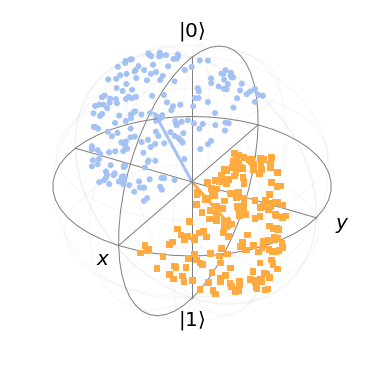

In [0]:
bloch = qutip.Bloch()
bloch.sphere_alpha = 0.0
bloch.frame_alpha = 0.05
bloch.vector_color[0] = bloch.point_color[0] = "#a4c2f4ff"
bloch.vector_color[1] = bloch.point_color[1] = "#ffab40ff"
bloch.add_points(bloch_p["a"])
bloch.add_points(bloch_p["b"])
vec = [[np.cos(theta_a),0,np.sin(theta_a)]]
bloch.add_vectors(vec)
vec = [[np.cos(theta_b),0,np.sin(theta_b)]]
bloch.add_vectors(vec)
bloch.show()

## Model

The quantum part of model will consist of an Y axis rotation and Z axis measurement.

Then feeded to a Neural Network with 2-unit softmax.

In [0]:
#We want to optimize 'theta'
theta = sympy.Symbol('theta')
q_model = cirq.Circuit(cirq.ry(theta)(qubit))

#input Layer
q_data_input = tf.keras.Input(
                              shape=(),
                              dtype=tf.dtypes.string
                             )
#Measurement Layer
expectation = tfq.layers.PQC(
                             q_model,
                             cirq.Z(qubit)
                            )
expectation_output = expectation(q_data_input)

#Classical part
classifier = tf.keras.layers.Dense(
                                   units=2,
                                   activation=tf.keras.activations.softmax
                                  )

classifier_output = classifier(expectation_output)

model = tf.keras.Model(
                      inputs=q_data_input,
                       outputs=classifier_output
                      )

### Compiling
Plotting and compiling the model

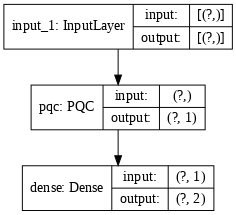

In [0]:
model.compile(
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              loss=tf.keras.losses.CategoricalCrossentropy()
             )

tf.keras.utils.plot_model(model, show_shapes=True, dpi=70)

### Training

In [0]:
history = model.fit(
                    x=q_data,
                    y=labels,
                    validation_split=0.1,
                    epochs=50,
                    verbose=0
                   )

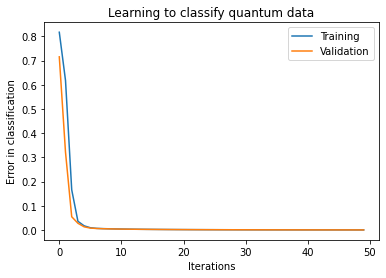

In [0]:
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Learning to classify quantum data")
plt.xlabel("Iterations")
plt.ylabel("Error in classification")
plt.legend()
plt.show()

## Testing the model

Testing the model

In [0]:
test_data, test_labels, _ = generate_dataset(qubit, 
                                             theta_a, 
                                             theta_b, 
                                             num_samples=100)

p = model.predict(test_data)[0]
label = test_labels[0]
print(f'prob(a)={p[0]:.4f}, prob(b)={p[1]:.4f}')
print(f'Label_a={label[0]}, label_b={label[1]}')

prob(a)=0.9999, prob(b)=0.0001
Label_a=1, label_b=0
